In [1]:
!nvidia-smi

!pip install tensorflow --upgrade

#Загрузка ImageDataAugmentor
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q
# Загрузка модели efficientnet
!pip install -q efficientnet

Tue Apr  6 20:30:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import efficientnet.tfkeras as efn
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [3]:
!pip freeze > requirements.txt

# Основные настройки

In [4]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 6  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [5]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [6]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [9]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


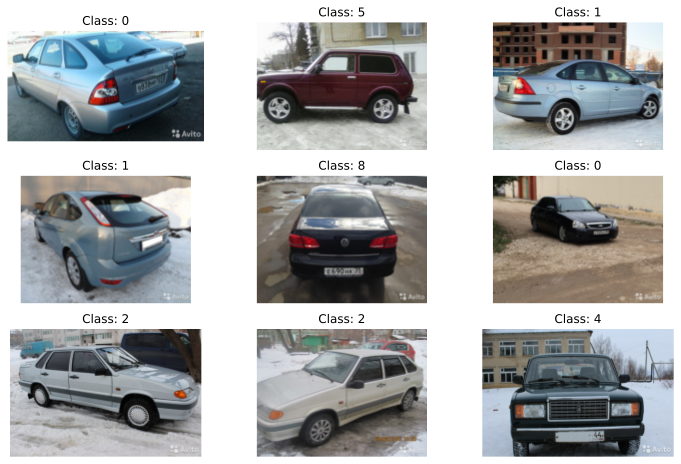

In [10]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры

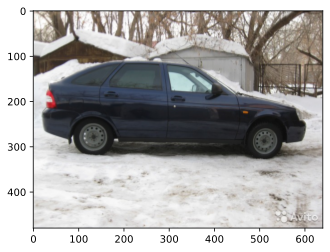

(640, 480)

In [11]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, 
                                  width=200),
        albumentations.CenterCrop(height=200, 
                                  width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, 
                            always_apply=False, 
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [13]:
train_datagen = ImageDataAugmentor(
    rescale=1. / 255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT, # set validation split
)

test_datagen = ImageDataAugmentor(rescale=1. / 255)

### Генерация данных

In [14]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


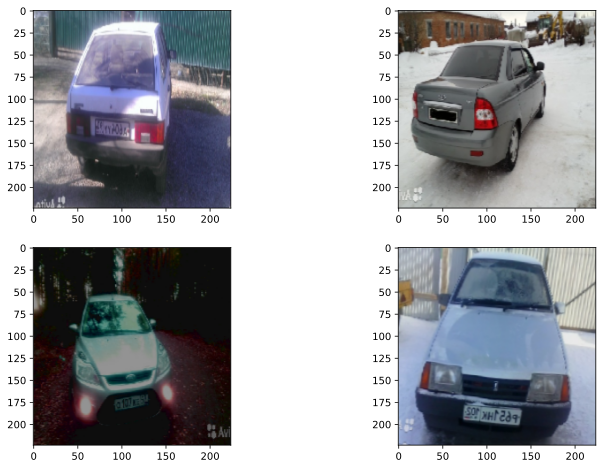

In [15]:
# Checking images.
x,y = train_generator.next()

plt.figure(figsize=(12,8))

for i in range(0,4):
    image = x[i]
    plt.subplot(2,2, i+1)
    plt.imshow(image)
plt.show()

# Построение модели

### Загружаем предобученную сеть:

Предобученная сеть Xception без заморозки слоев дала 0.94217. С учетом моделей на ImageNet наиболее подходящая EfficientNetB7

In [16]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

258441216/258434480 [==============================] - 7s 0us/step


In [17]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [18]:
# Чтобы не затереть признаки  - заморозим веса EfficientNetB7 и на первом этапе обучим только 'голову'
base_model.trainable = False

In [19]:
#Добавим свою архитерктуру выходного слоя
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) 

model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

In [21]:
len(model.trainable_variables)

6

### Step 1

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [22]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [23]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
389/389 [==============================] - 218s 507ms/step - loss: 2.0656 - accuracy: 0.3269 - val_loss: 1.1639 - val_accuracy: 0.5774

Epoch 00001: saving model to best_model.hdf5
Epoch 2/6
389/389 [==============================] - 193s 496ms/step - loss: 1.5140 - accuracy: 0.4680 - val_loss: 1.0554 - val_accuracy: 0.6211

Epoch 00002: saving model to best_model.hdf5
Epoch 3/6
389/389 [==============================] - 191s 490ms/step - loss: 1.3823 - accuracy: 0.5098 - val_loss: 1.0021 - val_accuracy: 0.6317

Epoch 00003: saving model to best_model.hdf5
Epoch 4/6
389/389 [==============================] - 193s 497ms/step - loss: 1.3290 - accuracy: 0.5254 - val_loss: 0.9635 - val_accuracy: 0.6623

Epoch 00004: saving model to best_model.hdf5
Epoch 5/6
389/389 [==============================] - 192s 492ms/step - loss: 1.2932 - accuracy: 0.5376 - val_loss: 0.9866 - val_accuracy: 0.6619

Epoch 00005: saving model to best_model.hdf5
Epoch 6/6
389/389 [==========================

In [24]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


98/98 [==============================] - 37s 378ms/step - loss: 0.8906 - accuracy: 0.6944
Accuracy: 69.44%


In [25]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

### Step 2

Обучение предобученных слоев будем проводить в 2 этапа - деля слои пополам

In [26]:
base_model.trainable = True

fine_tune_at = len(base_model.layers)//2

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [27]:
#Попробуем менять параметры - на всех этапах
EPOCHS               = 12  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4

In [28]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


In [29]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [30]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [31]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = EPOCHS,
    callbacks = callbacks_list
    )

Epoch 1/12
778/778 [==============================] - 278s 327ms/step - loss: 1.4081 - accuracy: 0.5209 - val_loss: 0.4150 - val_accuracy: 0.8544

Epoch 00001: saving model to best_model.hdf5
Epoch 2/12
778/778 [==============================] - 251s 322ms/step - loss: 0.5680 - accuracy: 0.7981 - val_loss: 0.2592 - val_accuracy: 0.9098

Epoch 00002: saving model to best_model.hdf5
Epoch 3/12
778/778 [==============================] - 251s 322ms/step - loss: 0.3987 - accuracy: 0.8633 - val_loss: 0.2089 - val_accuracy: 0.9249

Epoch 00003: saving model to best_model.hdf5
Epoch 4/12
778/778 [==============================] - 250s 322ms/step - loss: 0.3291 - accuracy: 0.8874 - val_loss: 0.1888 - val_accuracy: 0.9372

Epoch 00004: saving model to best_model.hdf5
Epoch 5/12
778/778 [==============================] - 252s 324ms/step - loss: 0.2541 - accuracy: 0.9127 - val_loss: 0.1817 - val_accuracy: 0.9343

Epoch 00005: saving model to best_model.hdf5
Epoch 6/12
778/778 [====================

In [32]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

195/195 [==============================] - 36s 186ms/step - loss: 0.1770 - accuracy: 0.9463
Accuracy: 94.63%


In [33]:
# Сохраним модель
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

###  Step 3

In [34]:
# Разморозим все слои
base_model.trainable = True

In [35]:
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

In [36]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


In [37]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [38]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
1557/1557 [==============================] - 636s 390ms/step - loss: 0.1900 - accuracy: 0.9364 - val_loss: 0.1533 - val_accuracy: 0.9540

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1557/1557 [==============================] - 608s 390ms/step - loss: 0.1566 - accuracy: 0.9462 - val_loss: 0.1511 - val_accuracy: 0.9569

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1557/1557 [==============================] - 609s 391ms/step - loss: 0.1314 - accuracy: 0.9538 - val_loss: 0.1492 - val_accuracy: 0.9585

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1557/1557 [==============================] - 612s 393ms/step - loss: 0.1196 - accuracy: 0.9598 - val_loss: 0.1453 - val_accuracy: 0.9585

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1557/1557 [==============================] - 609s 391ms/step - loss: 0.1115 - accuracy: 0.9604 - val_loss: 0.1542 - val_accuracy: 0.9569

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1557/1557 [========

In [39]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [40]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 40s 103ms/step - loss: 0.1467 - accuracy: 0.9614
Accuracy: 96.14%


В Итоге точность нашей модели составила %. 
Посмотрим графики обучения:

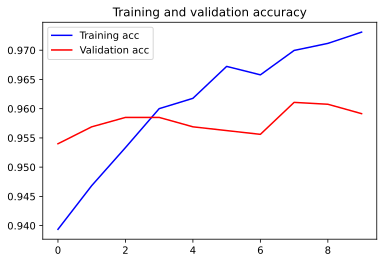

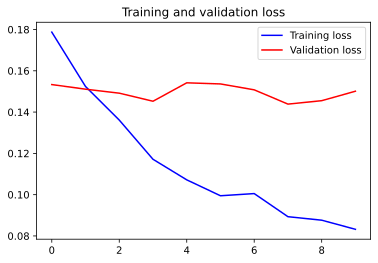

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [42]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

# Предсказание на тестовых данных

In [43]:
model.load_weights('best_model.hdf5')

In [44]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #preprocess_input=None,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False
)

In [45]:
test_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [46]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, steps = len(test_generator), verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


835/835 [==============================] - 129s 155ms/step


In [47]:
predictions = np.argmax(pred, axis=-1)

In [48]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
predictions = [label_map[k] for k in predictions]

In [49]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [50]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

835/835 [==============================] - 97s 113ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Accuracy: 0.00%


In [51]:
# Clean PATH
import shutil
shutil.rmtree(PATH)